In [34]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

#from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score, mean_absolute_error as mae, f1_score, mean_squared_error as mse, confusion_matrix


from pylab import rcParams
rcParams['figure.figsize'] = 15, 11

#%matplotlib inline

In [3]:
df = pd.read_csv(r'C:\Users\adima\Desktop\projects\python\ascm_math_algs_project\ascm_project\data\final_data_predict.csv', index_col=0)
df

TMIN       TMAX  ELECTRIC_PROD  BEER_PROD
DATE                                                      
1985-01-01  38.193548  50.516129        72.5052       93.2
1985-02-01  37.821429  50.535714        70.6720       96.0
1985-03-01  41.612903  55.967742        62.4502       95.2
1985-04-01  42.066667  57.066667        57.4714       77.1
1985-05-01  46.870968  62.516129        55.3151       70.9
...               ...        ...            ...        ...
2017-09-01  56.466667  70.433333        98.6154      145.1
2017-10-01  45.741935  57.612903        93.6137      183.7
2017-11-01  42.066667  53.700000        97.3359      210.5
2017-12-01  34.774194  44.645161       114.7212      203.3
2018-01-01  39.354839  49.290323       129.4048      153.3

[397 rows x 4 columns]

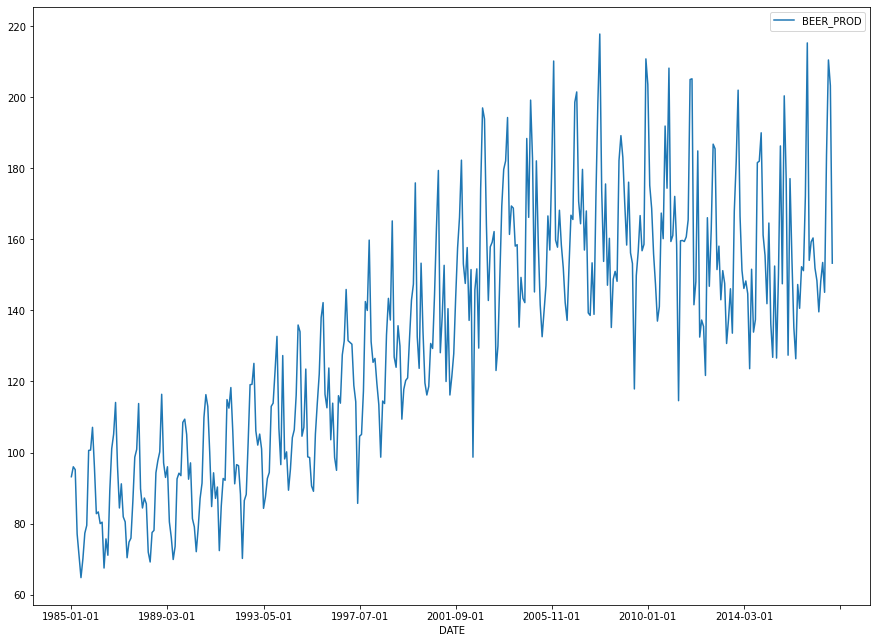

In [4]:
df1 = df['BEER_PROD'].to_frame()
df1.plot();


BEER_PROD
count  397.000000
mean   133.086650
std     34.797285
min     64.800000
25%    104.200000
50%    135.300000
75%    158.400000
max    217.800000

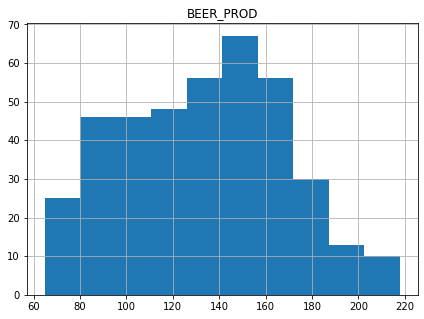

In [5]:

df1.hist(figsize=(7,5));
df1.describe()

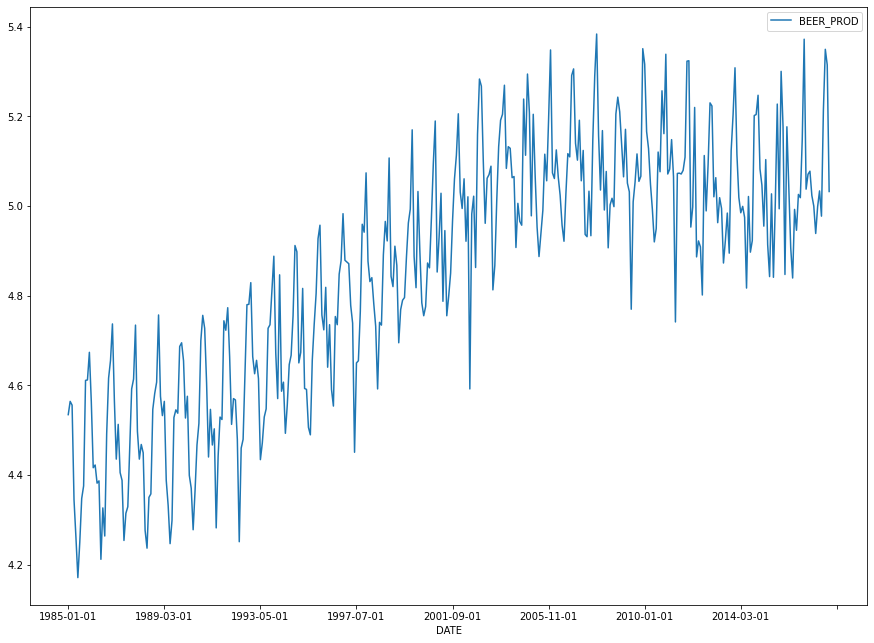

In [6]:
df1_log = np.log(df1)
df1_log.plot();

In [7]:
ad_fuller_result = adfuller(df1_log)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.01949967277551
p-value: 0.27808915887478847


In [8]:
df1_log_diff = df1_log.diff()
df1_log_diff= df1_log_diff.dropna()


<AxesSubplot:xlabel='DATE'>

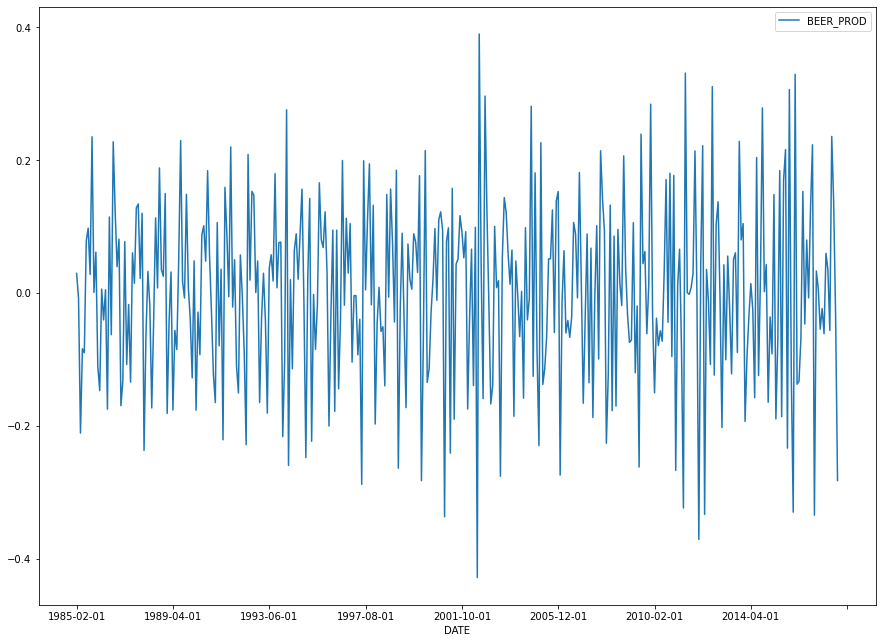

In [9]:
df1_log_diff.plot()

In [10]:
# ad_fuller_result = adfuller(df1)
# print(f'ADF Statistic: {ad_fuller_result[0]}')
# print(f'p-value: {ad_fuller_result[1]}')

In [11]:
df_season = df1_log_diff.diff(12).dropna()

<AxesSubplot:xlabel='DATE'>

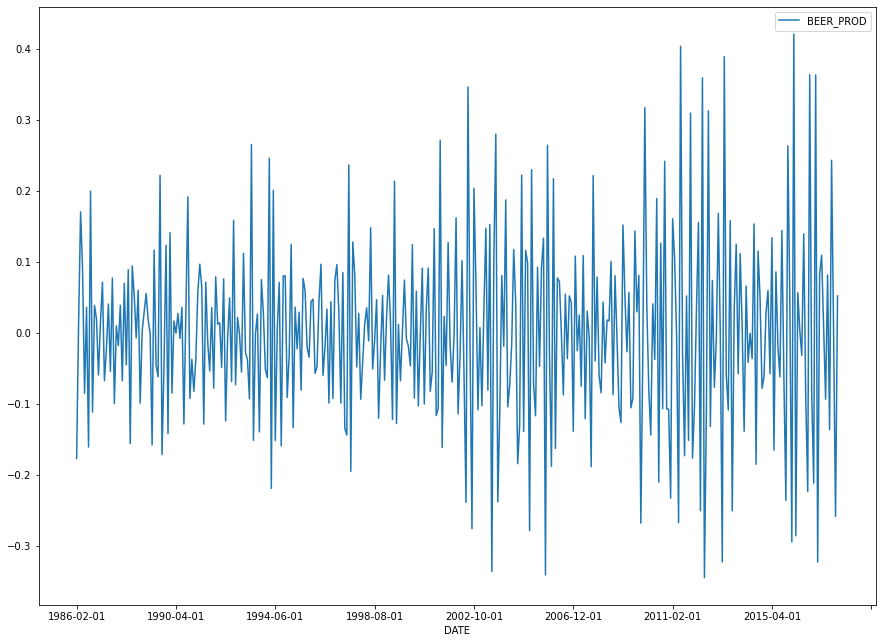

In [12]:
df_season.plot()

In [13]:
ad_fuller_result = adfuller(df_season)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -7.861688380763665
p-value: 5.263518587833746e-12


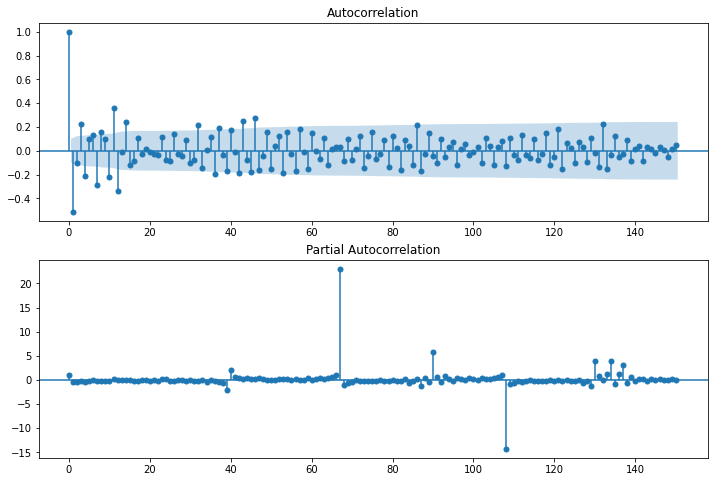

In [14]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_season.values.squeeze(), lags=150, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_season, lags=150, ax=ax2)

In [15]:
def exp_smoothing(df, alpha):
    df_ex = df.ewm(alpha=alpha, adjust=True).mean().dropna()

    return df_ex

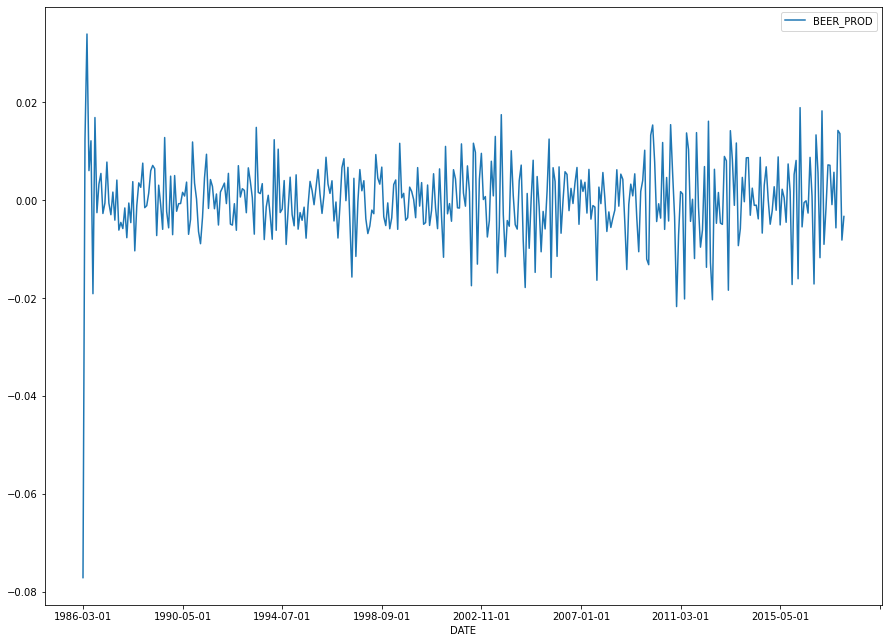

In [16]:
df_season_smth = exp_smoothing(df_season, 0.08)
df_season_smth =df_season_smth.drop(['1986-02-01']) #'1986-03-01'

df_season_smth.plot();

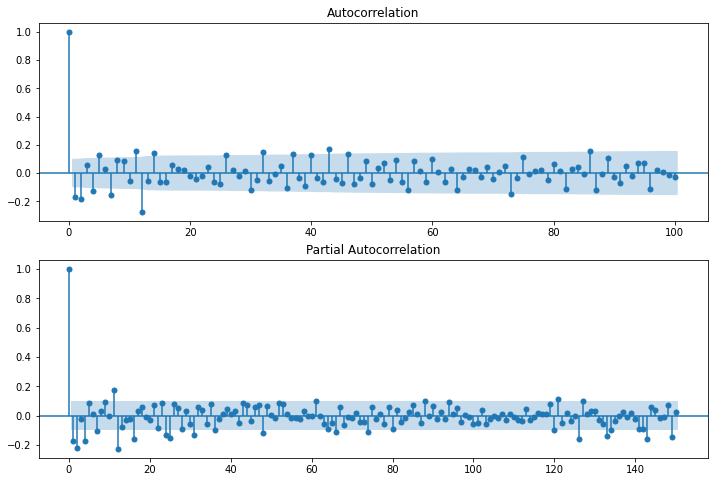

In [17]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_season_smth.values.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_season_smth, lags=150, ax=ax2)

In [18]:
df_train, df_test = df1.iloc[:round(len(df1)*0.9), :], df1.iloc[round(len(df1)*0.9): , :]

In [19]:
df_train

BEER_PROD
DATE                 
1985-01-01       93.2
1985-02-01       96.0
1985-03-01       95.2
1985-04-01       77.1
1985-05-01       70.9
...               ...
2014-05-01      144.7
2014-06-01      123.6
2014-07-01      151.6
2014-08-01      133.9
2014-09-01      137.4

[357 rows x 1 columns]

In [20]:
# model = SARIMAX(df_train['BEER_PROD'], order=(12, 1, 12), seasonal_order=( 0, 1, 0, 12)).fit(dis=-1)

In [21]:
model = SARIMAX(df_train['BEER_PROD'], order=(3, 1, 12), seasonal_order=( 0, 1, 0, 12)).fit(dis=-1)

In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            BEER_PROD   No. Observations:                  357
Model:             SARIMAX(3, 1, 12)x(0, 1, [], 12)   Log Likelihood               -1267.007
Date:                              Thu, 24 Dec 2020   AIC                           2566.015
Time:                                      02:06:32   BIC                           2627.465
Sample:                                  01-01-1985   HQIC                          2590.490
                                       - 09-01-2014                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8472      0.075    -11.335      0.000      -0.994      -0.701
ar.L2         -0.7473      0.088     -8.481      0.000      -0.920      -0.575
ar.L3         -0.3591      0.077     -4.679      0.000      -0.509      -0.209
ma.L1         -0.0622      0.072     -0.867      0.386      -0.203       0.078
ma.L2         -0.1097      0.059     -1.869      0.062      -0.225       0.005
ma.L3         -0.3047      0.054     -5.675      0.000      -0.410      -0.199
ma.L4         -0.3949      0.072     -5.489      0.000      -0.536      -0.254
ma.L5          0.1023      0.051      2.021      0.043       0.003       0.201
ma.L6          0.1428      0.051      2.775      0.006       0.042       0.244
ma.L7         -0.0880      0.052     -1.684      0.092      -0.190       0.014
ma.L8          0.0669      0.047      1.428      0.153      -0.025       0.159
ma.L9          0.0545      0.049      1.110      0.267      -0.042       0.151
ma.L10        -0.0031      0.053     -0.059      0.953      -0.106       0.100
ma.L11         0.2943      0.042      7.030      0.000       0.212       0.376
ma.L12        -0.6436      0.057    -11.304      0.000      -0.755      -0.532
sigma2        87.2919      5.676     15.380      0.000      76.168      98.416
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                61.42
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               5.29   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

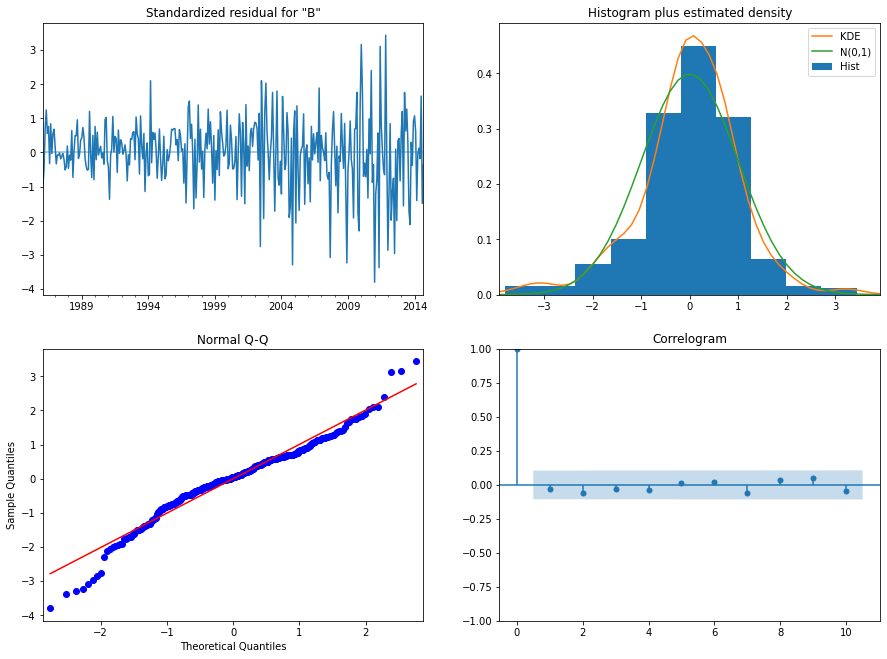

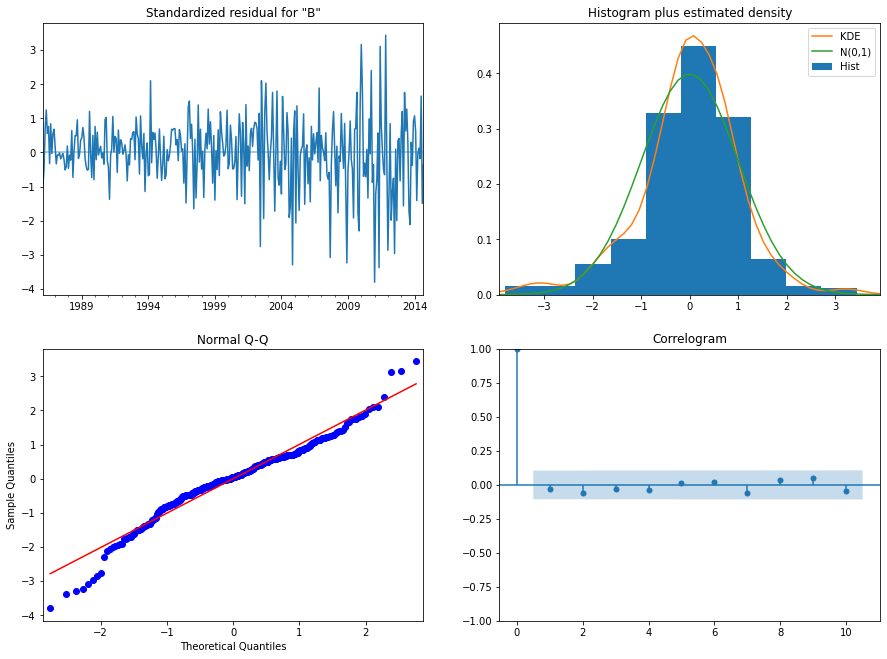

In [23]:
#plt.style.use('default')
model.plot_diagnostics()

In [24]:
df_train['sarima_fitted'] = model.fittedvalues
df_train

BEER_PROD  sarima_fitted
DATE                                
1985-01-01       93.2       0.000000
1985-02-01       96.0      93.193659
1985-03-01       95.2      95.998959
1985-04-01       77.1      95.201213
1985-05-01       70.9      77.101636
...               ...            ...
2014-05-01      144.7     143.515266
2014-06-01      123.6     125.270948
2014-07-01      151.6     136.137571
2014-08-01      133.9     147.853455
2014-09-01      137.4     140.806634

[357 rows x 2 columns]

In [25]:
pred = model.predict(start =df_test.index[0], end = df_test.index[-1])
pred

2014-10-01    167.224378
2014-11-01    185.216396
2014-12-01    204.065768
2015-01-01    165.916031
2015-02-01    141.013190
2015-03-01    156.687278
2015-04-01    150.073225
2015-05-01    139.514804
2015-06-01    128.842480
2015-07-01    142.312654
2015-08-01    139.595932
2015-09-01    139.705230
2015-10-01    166.422495
2015-11-01    184.200762
2015-12-01    206.770653
2016-01-01    166.744232
2016-02-01    140.727767
2016-03-01    157.411857
2016-04-01    151.448178
2016-05-01    139.983845
2016-06-01    129.230343
2016-07-01    143.212749
2016-08-01    140.448003
2016-09-01    140.244347
2016-10-01    167.078714
2016-11-01    185.008884
2016-12-01    207.474942
2017-01-01    167.380926
2017-02-01    141.444779
2017-03-01    158.148619
2017-04-01    152.132457
2017-05-01    140.668990
2017-06-01    129.946883
2017-07-01    143.920889
2017-08-01    141.139488
2017-09-01    140.944946
2017-10-01    167.787054
2017-11-01    185.709835
2017-12-01    208.173096
2018-01-01    168.084192


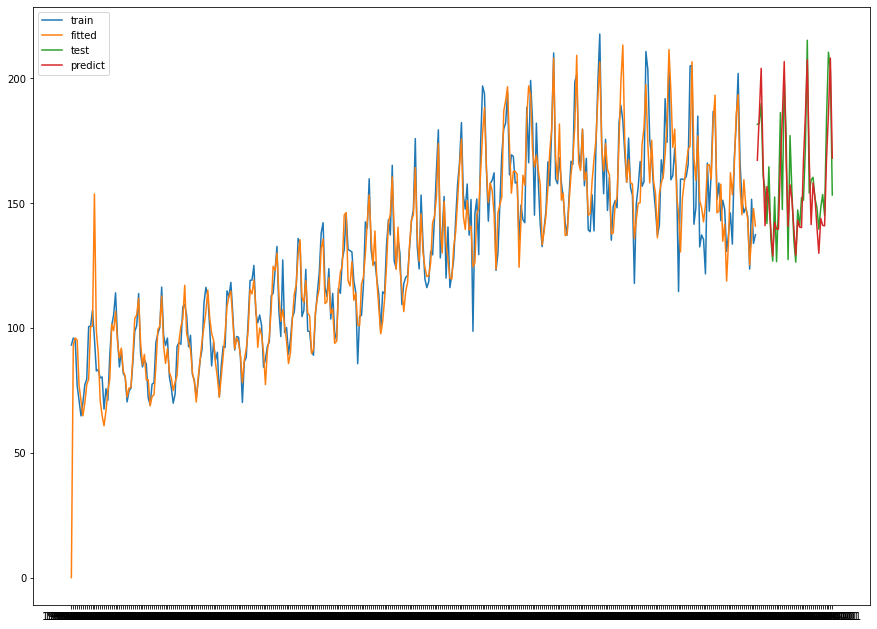

In [26]:
plt.plot(df_train.index, df_train['BEER_PROD'], label='train')

plt.plot(df_train.index, df_train['sarima_fitted'], label='fitted')
plt.plot(df_test.index, df_test['BEER_PROD'], label='test')
plt.plot(df_test.index, pred, label='predict')
plt.legend(loc="upper left")
plt.show()

In [192]:
# df1.plot();

In [197]:
np.sqrt(mse(pred.values, df_test['BEER_PROD']))

14.498518692106032

In [204]:
np.sqrt(mse(pred.values, df_test['BEER_PROD']))

15.349611848354224

In [211]:
np.sqrt(mse(pred.values, df_test['BEER_PROD']))

14.59840624225799

In [218]:
np.sqrt(mse(pred.values, df_test['BEER_PROD']))

14.377427124299548

In [225]:
np.sqrt(mse(pred.values, df_test['BEER_PROD']))

15.22627957559745

In [232]:
np.sqrt(mse(pred.values, df_test['BEER_PROD']))

13.14052490128444

In [239]:
np.sqrt(mse(pred.values, df_test['BEER_PROD']))

13.468603422435008

### Model evaluation

In [45]:
print('RMSE: {}\n'.format(np.sqrt(mse(pred.values, df_test['BEER_PROD']))) + \
     'R square: {}\n'.format(r2_score(pred.values, df_test['BEER_PROD'])) + \
     'Mean Absolute Error: {}\n'.format(mae(pred.values, df_test['BEER_PROD'])) + \
     'Correlation coefficients: {}\n'.format(np.corrcoef(pred.values, df_test['BEER_PROD'])[0]) + \
     'Covariance matrix: \n', np.cov(pred.values, df_test['BEER_PROD']))

RMSE: 12.806818667893447
R square: 0.6722866652941593
Mean Absolute Error: 10.526584132107214
Correlation coefficients: [1.         0.84256647]
Covariance matrix: 
 [[513.31480674 443.30992395]
 [443.30992395 539.29050641]]


In [27]:
np.sqrt(mse(pred.values, df_test['BEER_PROD']))   #order=(3, 1, 12), seasonal_order=( 0, 1, 0, 12))

12.806818667893447

In [28]:
r2 = r2_score(pred.values, df_test['BEER_PROD']) #determ coof
r2

0.6722866652941593

In [29]:
meam_a_e = mae(pred.values, df_test['BEER_PROD']) #mean_absolute_error
meam_a_e 

10.526584132107214

In [32]:
np.corrcoef(pred.values, df_test['BEER_PROD'])

array([[1.        , 0.84256647],
       [0.84256647, 1.        ]])

In [37]:
np.cov(pred.values, df_test['BEER_PROD'])

array([[513.31480674, 443.30992395],
       [443.30992395, 539.29050641]])

In [256]:
import pickle    
with open('./learned_model.pkl', 'wb') as model_pkl:
    pickle.dump(model, model_pkl)